# Sentiment Analysis
## Table of contents
* [Overview](#section-1)
* [Dataset](#section-2)
* [Objective](#section-3)
* [Costs](#section-4)
* [Data Loading](#section-5)
* [Preparing training data](#section-6)
* [Creating Dataset in VertexAI](#section-7)
* [Training the model using vertex AI](#section-8)
* [Deloy the Model to the end point](#section-9)
* [Prediction](#section-10)
* [Reviews visualisation](#section-11)
* [Clean-up](#section-12)

## Overview
<a name="section-1"></a>
This notebook demonstrates performing sentiment analysis on stanford movie reviews dataset using AutoML NLP, deploying the sentimental model on vertex-AI and getting predictions. 
<b>Note</b>: This notebook is designed to run on managed notebooks instance of Vertex AI Workbench. Some components of this notebook may not work in other notebook environments.

## Dataset
<a name="section-2"></a>
The dataset used in this notebook is a part of the [Stanford Sentiment Treebank Dataset](https://nlp.stanford.edu/sentiment/) which consists of all movie review phrases and the corresponding sentiment scores.

## Objective
<a name="section-3"></a>
In this notebook :

- Loading the required data. 
- Preprocessing the data 
- Selecting the required data for the model.
- Load the dataset into vertexAI Managed datasets.
- Training a sentimental model using AutoML NLP.
- Evaluating the model.
- Deploying the model on Vertex-AI.
- Getting Predictions
- Clean up.


## Costs
<a name="section-4"></a>
This tutorial uses the following billable components of Google Cloud:

- Vertex AI
- Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Kernel selection
Select <b>Python</b> kernel while running this notebook on Vertex-AIs managed instances and ensure that the following libraries are installed in the environment where this notebook is being run.
- wordcloud
- Pandas 


Along with the above libraries, the following google-cloud libraries are also used in this notebook.

- google.cloud.aiplatform
- google.cloud.storage



### Install additional packages


In [ ]:
! pip install wordcloud

## Set your project ID

In [1]:
PROJECT_ID = "vertex-ai-dev"


#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [2]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

## Import the required libraries and define constants

In [4]:
import pandas as pd 
from typing import List, Union,Optional,Dict,Sequence,Tuple
import random
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import os

from google.cloud import storage
from google.cloud import aiplatform

In [ ]:
LOCATION = "us-central1"
BUCKET_NAME ="{your-bucket-name}"


## Loading data 
<a name="section-5"></a>

In [5]:
phrases =pd.read_csv('gs://vertex_ai_managed_services_demo/sentiment_analysis/stanfordSentimentTreebank/dictionary.txt',sep='|')
phrases.columns=['text','phrase ids']
scores=pd.read_csv('gs://vertex_ai_managed_services_demo/sentiment_analysis/stanfordSentimentTreebank/sentiment_labels.txt',sep='|')
df=phrases.merge(scores,how='left',on='phrase ids')
print(df.head(5))

            text  phrase ids  sentiment values
0            ! '       22935           0.52778
1           ! ''       18235           0.50000
2         ! Alas      179257           0.44444
3    ! Brilliant       22936           0.86111
4  ! Brilliant !       40532           0.93056


In [8]:
print(max(df["sentiment values"]),min(df["sentiment values"]))

1.0 0.0


The data itself doesn't contain any feature names and thus needs its columns to be re-named. dictionary.txt contains all phrases and their IDs, separated by a vertical line |. sentiment_labels.txt contains all phrase ids and the corresponding sentiment scores, separated by a vertical line.4 classes are created by mapping the positivity probability using the following cut-offs:
[0, 0.25], (0.25, 0.5], (0.5, 0.75],(0.75, 1.0]

### Creating labels 

In [6]:
bins = [0, 0.25,0.5,0.75,1]
labels = [0,1,2,3]
df['label'] = pd.cut(df['sentiment values'], bins=bins, labels=labels)
print (df.head())

            text  phrase ids  sentiment values label
0            ! '       22935           0.52778     2
1           ! ''       18235           0.50000     1
2         ! Alas      179257           0.44444     1
3    ! Brilliant       22936           0.86111     3
4  ! Brilliant !       40532           0.93056     3


## Preparing training data
<a name="section-6"></a>

To train a sentiment analysis model, you provide representative samples of the type of content you want AutoML Natural Language to analyze, each labeled with a value indicating how positive the sentiment is within the content.

The sentiment score is an integer ranging from 0 (relatively negative) to a maximum value of your choice (positive). For example, if you want to identify whether the sentiment is negative, positive, or neutral, you would label the training data with sentiment scores of 0 (negative), 1 (neutral), and 2 (positive).If you want to capture more granularity with five levels of sentiment, you still label documents with the most negative sentiment as 0 and use 4 for the most positive sentiment. The Maximum sentiment score (sentiment_max) for the dataset would be 4.

For this notebook we are selecting subset of the orginal data to train on, which consists extreme positive and negative samples. Here the maximum sentiment would be 1. In <i>ML use</i> column we could provide if it is a TRAIN/VALIDATION/TEST sample or let the vertex ai randomly assign. 
Each line in a CSV file refers to a single document. The following example shows the general format of a valid CSV file. The ml_use column is optional.

[ml_use],gcs_file_uri|"inline_text",sentiment,sentimentMax


### Selecting subset data

In [10]:
subset_data = df[df["label"].isin([0,3])].reset_index(drop=True)
subset_data.head()

,text,phrase ids,sentiment values,label
0,! Brilliant,22936,0.86111,3
1,! Brilliant !,40532,0.93056,3
2,! Brilliant ! ',22937,1.00000,3
3,! Gollum 's ` performance ' is incredible,13402,0.76389,3
4,"! The camera twirls ! Oh , look at that clever...",179260,0.22222,0


In [11]:
subset_data["label"] = subset_data["label"].apply( lambda x: 1 if x == 3 else 0)
subset_data["ml_use"] = ""
subset_data["sentimentMax"] = 1
subset_data = subset_data[["ml_use", "text","label", "sentimentMax"]]
print(subset_data.head())

  ml_use                                               text  label  \
0                                               ! Brilliant      1   
1                                             ! Brilliant !      1   
2                                           ! Brilliant ! '      1   
3                 ! Gollum 's ` performance ' is incredible      1   
4         ! The camera twirls ! Oh , look at that clever...      0   

   sentimentMax  
0             1  
1             1  
2             1  
3             1  
4             1  


### Creating an import csv

In [12]:
FILE_NAME = "sentiment_data.csv"
subset_data.to_csv(FILE_NAME,index=False)
# Upload the saved model file to Cloud Storage
BLOB_PATH = "sentiment_analysis/"
BLOB_NAME = os.path.join(BLOB_PATH, FILE_NAME)
bucket = storage.Client().bucket(BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)
blob.upload_from_filename(FILE_NAME)

## Creating Dataset in VertexAI
<a name="section-7"></a>

The following code uses the Vertex AI SDK for Python to both create a dataset and import data. 

In [15]:
def import_data_text_sentiment_analysis(
    project: str,
    location: str,
    display_name: str,
    src_uris: Union[str, List[str]],
    sync: bool = True,
):
    aiplatform.init(project=project, location=location)

    ds = aiplatform.TextDataset.create(
        display_name=display_name,
        gcs_source=src_uris,
        import_schema_uri=aiplatform.schema.dataset.ioformat.text.sentiment,
        sync=sync,
    )

    ds.wait()

    print(ds.display_name)
    print(ds.resource_name)
    return ds

In [16]:
display_name = "sentimentanalysis"
src_uris = ["gs://vertex_ai_managed_services_demo/sentiment_analysis/sentiment_data.csv"]
dataset = import_data_text_sentiment_analysis(PROJECT_ID,LOCATION,display_name,src_uris)

INFO:google.cloud.aiplatform.datasets.dataset:Creating TextDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TextDataset backing LRO: projects/931647533046/locations/us-central1/datasets/7186623503422980096/operations/3417113982568235008
INFO:google.cloud.aiplatform.datasets.dataset:TextDataset created. Resource name: projects/931647533046/locations/us-central1/datasets/7186623503422980096
INFO:google.cloud.aiplatform.datasets.dataset:To use this TextDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TextDataset('projects/931647533046/locations/us-central1/datasets/7186623503422980096')
INFO:google.cloud.aiplatform.datasets.dataset:Importing TextDataset data: projects/931647533046/locations/us-central1/datasets/7186623503422980096
INFO:google.cloud.aiplatform.datasets.dataset:Import TextDataset data backing LRO: projects/931647533046/locations/us-central1/datasets/7186623503422980096/operations/3167164203249172480
INFO:google.cloud.aipl

## Training the model using vertex AI
<a name="section-8"></a>

The following code uses the Vertex AI SDK for Python to train the model on the above created dataset. You can get the dataset id from the datasets section of vertexAI in the console or get from the resource name in the dataset object created above. We can specify how the training data is split between the training, validation, and test sets by setting the fraction_split variables.

In [23]:
def create_training_pipeline_text_sentiment_analysis(
    project: str,
    location: str,
    display_name: str,
    dataset_id: str,
    model_display_name: Optional[str] = None,
    sentiment_max: int = 10,
    training_fraction_split: float = 0.8,
    validation_fraction_split: float = 0.1,
    test_fraction_split: float = 0.1,
    sync: bool = True,
):
    aiplatform.init(project=project, location=location)

    job = aiplatform.AutoMLTextTrainingJob(
        display_name=display_name,
        prediction_type="sentiment",
        sentiment_max=sentiment_max,
    )

    text_dataset = aiplatform.TextDataset(dataset_id)

    model = job.run(
        dataset=text_dataset,
        model_display_name=model_display_name,
        training_fraction_split=training_fraction_split,
        validation_fraction_split=validation_fraction_split,
        test_fraction_split=test_fraction_split,
        sync=sync,
    )

    model.wait()

    print(model.display_name)
    print(model.resource_name)
    print(model.uri)
    return model


In [25]:
display_name = "sentimentanalysis"
dataset_id = dataset.resource_name.split('/')[-1]
print(dataset_id)
model = create_training_pipeline_text_sentiment_analysis(PROJECT_ID,LOCATION,display_name,dataset_id,sentiment_max = 1)

7186623503422980096


## Deloy the Model to the end point
<a name="section-9"></a>


#### create the end point

In [41]:

def create_endpoint(
    project: str, display_name: str, location: str,
):
    aiplatform.init(project=project, location=location)

    endpoint = aiplatform.Endpoint.create(
        display_name=display_name, project=project, location=location,
    )

    print(endpoint.display_name)
    print(endpoint.resource_name)
    return endpoint


In [42]:
display_name = "sentiment-analysis"
endpoint = create_endpoint(PROJECT_ID,display_name,LOCATION)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/931647533046/locations/us-central1/endpoints/440868978366087168/operations/2087707667563806720
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/931647533046/locations/us-central1/endpoints/440868978366087168
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/931647533046/locations/us-central1/endpoints/440868978366087168')
sentiment-analysis
projects/931647533046/locations/us-central1/endpoints/440868978366087168


#### Deploy the model

The following code uses the Vertex AI SDK for Python to deploy the model to a endpoiny. You can get the model id from the models section of vertexAI in the console

In [43]:
def deploy_model_with_automatic_resources(
    project,
    location,
    model_name: str,
    endpoint: Optional[aiplatform.Endpoint] = None,
    deployed_model_display_name: Optional[str] = None,
    traffic_percentage: Optional[int] = 0,
    traffic_split: Optional[Dict[str, int]] = None,
    min_replica_count: int = 1,
    max_replica_count: int = 1,
    metadata: Optional[Sequence[Tuple[str, str]]] = (),
    sync: bool = True,
):
    """
        model_name: A fully-qualified model resource name or model ID.
              Example: "projects/123/locations/us-central1/models/456" or
              "456" when project and location are initialized or passed.
    """

    aiplatform.init(project=project, location=location)

    model = aiplatform.Model(model_name=model_name)
    model.deploy(
        endpoint=endpoint,
        )
    model.wait()
    print(model.display_name)
    print(model.resource_name)
    return model


In [44]:
model_id = ""
model = deploy_model_with_automatic_resources(PROJECT_ID,LOCATION,model_id,endpoint)

INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/931647533046/locations/us-central1/endpoints/440868978366087168
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/931647533046/locations/us-central1/endpoints/440868978366087168/operations/2334279747162341376
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/931647533046/locations/us-central1/endpoints/440868978366087168
sentimentanalysis
projects/931647533046/locations/us-central1/models/168256065375305728


## Prediction
<a name="section-10"></a>


After deploying the model to an end point use the Vertex AI API to request an online prediction. Filter the data which we haven't used for the training and pick  longer reviews to test the model 

In [45]:
def predict_text_sentiment_analysis_sample(endpoint, content):
    print(content)
    response = endpoint.predict(instances=[{"content": content}], parameters={})

    for prediction_ in response.predictions:
        print(prediction_)


In [56]:
test_data_pos = df[df["label"].isin([2])].reset_index(drop=True)
test_data_neg = df[df["label"].isin([1])].reset_index(drop=True)

test_data_neg = test_data_neg.text.values
test_data_neg = [i for i in test_data_neg if len(i) >200]
random.shuffle(test_data_neg)

In [57]:
test_data_pos = test_data_pos.text.values
test_data_pos = [i for i in test_data_pos if len(i) >200]
random.shuffle(test_data_pos)

Here is the prediction results on the positive samples. Model did good job on predicting positive sentiment for positive reviews.First and last review predictions are false negavtives. 


In [58]:
for review in test_data_pos[0:10]:
    predict_text_sentiment_analysis_sample(endpoint, review)

Byler is too savvy a filmmaker to let this morph into a typical romantic triangle . Instead , he focuses on the anguish that can develop when one mulls leaving the familiar to traverse uncharted ground .
{'sentiment': 0.0}
writer-director david jacobson and his star , jeremy renner , have made a remarkable film that explores the monster 's psychology not in order to excuse him but rather to demonstrate that his pathology evolved from human impulses that grew hideously twisted
{'sentiment': 1.0}
It 's too harsh to work as a piece of storytelling , but as an intellectual exercise -- an unpleasant debate that 's been given the drive of a narrative and that 's been acted out -- The Believer is nothing less than a provocative piece of work
{'sentiment': 1.0}
A compelling coming-of-age drama about the arduous journey of a sensitive young girl through a series of foster homes and a fierce struggle to pull free from her dangerous and domineering mother 's hold over her .
{'sentiment': 1.0}
In 

Here is the prediction results on the negative reviews. Out of 10 reviews below 7 negative reviews are correctly predicted with negative sentiment

In [55]:
for review in test_data_neg[0:10]:
    predict_text_sentiment_analysis_sample(endpoint, review)

of sophisticated , challenging filmmaking that stands , despite its noticeable lack of emotional heft , in welcome contrast to the indulgent dead-end experimentation of the director 's previous Full Frontal
{'sentiment': 1.0}
, despite a definitely distinctive screen presence , just is n't able to muster for a movie that , its title notwithstanding , should have been a lot nastier if it wanted to fully capitalize on its lead 's specific gifts
{'sentiment': 0.0}
It throws quirky characters , odd situations , and off-kilter dialogue at us , all as if to say , '' Look at this ! This is an interesting movie ! '' But the film itself is ultimately quite unengaging .
{'sentiment': 0.0}
If you are curious to see the darker side of what 's going on with young TV actors ( Dawson Leery did what ?!? ) , or see some interesting storytelling devices , you might want to check it out , but there 's nothing very attractive about this movie .
{'sentiment': 0.0}
got Ten Little Indians meets Friday the 13

## Reviews visualisation
<a name="section-11"></a>


Here we are trying to visualise the positive and negative reviews in the data.

In [53]:
data_pos = df[df["label"].isin([3])].reset_index(drop=True)
data_neg = df[df["label"].isin([0])].reset_index(drop=True)

data_neg = data_neg.text.values

In [54]:
data_pos = data_pos.text.values

Creating the word cloud by removing the common words to highlight the words representing positive and negative samples 

In [55]:
# Python program to generate WordCloud
def plot_word_cloud(data,common_words):
    comment_words = ''
    stopwords = set(STOPWORDS)
    for val in data:
        tokens = val.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
            for each in common_words :
                if each in tokens[i] :
                    tokens[i] = ''
                    break
                
        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(comment_words)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()


Word cloud of negative reviews

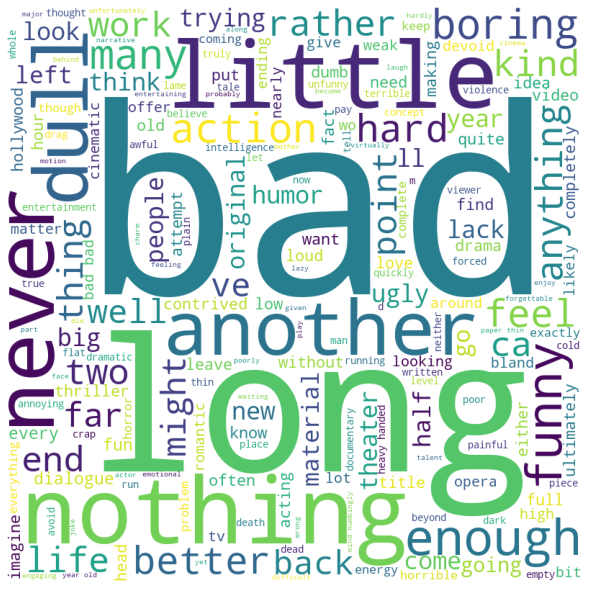

In [56]:
plot_word_cloud(data_neg,["movie","film", "story","audience","director","watch","seem","world","one","make","way","character","much","time","even",
               "take","s","n't","will","may","re","plot","good","comedy","made"])

Word cloud of positive reviews

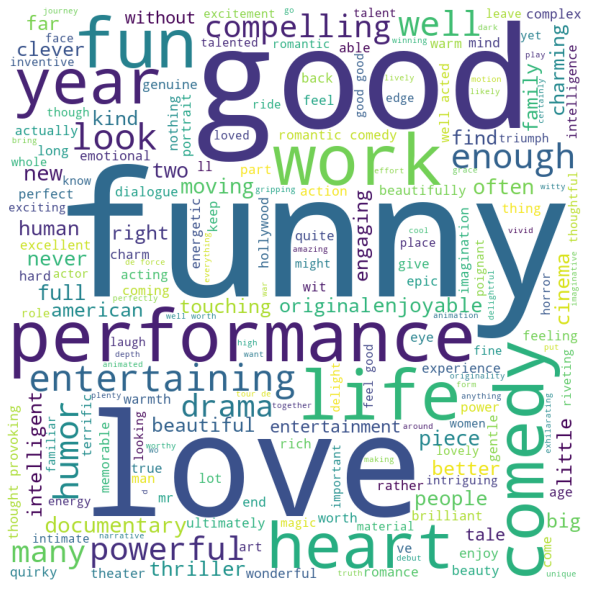

In [ ]:
plot_word_cloud(data_pos,["movie","film", "story","audience","director","watch","seem","world","one","make","way","character","much","time","even",
               "take","s","n't","will","may","re","plot","made"])

## Clean up
<a name="section-12"></a>

Undeploy the model from endpoint.

In [ ]:
DEPLOYED_MODEL_ID = ""
endpoint.undeploy(deployed_model_id=DEPLOYED_MODEL_ID)

Delete the endpoint.

In [ ]:
endpoint.delete()